In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
from functools import partial
import jax.numpy as jnp

plt.rcParams['figure.figsize'] = [12, 8]

import time
from tqdm import tqdm
from sklearn.gaussian_process.kernels import ExpSineSquared


from Dynamics import *
from Kernels import * 
from Losses import *

%load_ext autoreload
%autoreload 2


In [2]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)



In [328]:
# Get the Dataset 
r = 4
curr_map = logistic_map(r)
x0 = 0.1
N = 200
traj = np.array(gen_traj(curr_map, x0, N))


X = traj[:-1]
Y = traj[1:]

N_sub = 100

b_idxs = np.random.choice(len(X), N_sub)
c_idxs = None # np.random.choice(len(X), N_sub)
Xb = X[b_idxs].reshape(-1, 1)
yb = Y[b_idxs]

if c_idxs is None:
    Xc = X.reshape(-1, 1)
    yc = Y
else:
    Xc = X[c_idxs].reshape(-1, 1)
    yc = Y[c_idxs]

Xb = jnp.array(Xb)
yb = jnp.array(yb)

Xc = jnp.array(Xc)
yc = jnp.array(yc)

In [329]:
theta = jnp.array([1.,1.,1.,1.])

rho_comp(theta, logistic_kernel, Xb, yb, Xc, yc)

Array(0.01895024, dtype=float64)

In [330]:

delta = 0.1
num_steps = 50

theta = jnp.array([1.,1.,1.,1.])

k_func = logistic_kernel

losses = []

for _ in range(num_steps):
    curr_loss = rho_comp(theta, k_func, Xb, yb, Xc, yc)
    losses.append(curr_loss)
    theta -= delta * jax.grad(rho_comp, argnums=0)(theta, k_func, Xb, yb, Xc, yc)


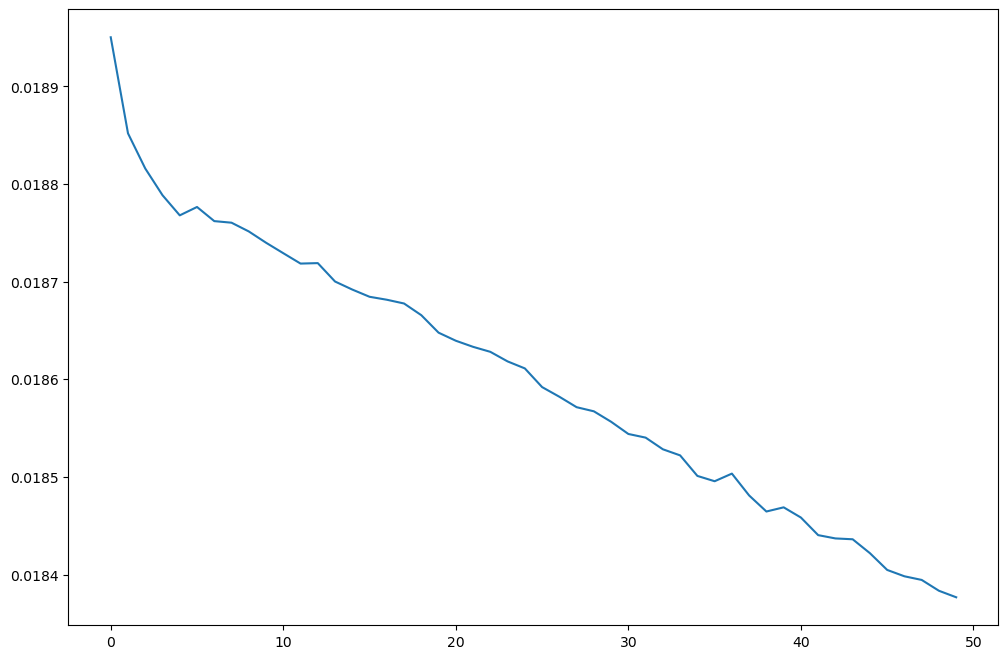

In [331]:
plt.plot(losses)

In [332]:
theta

Array([1.00241747, 1.0467629 , 0.99308754, 1.00719914], dtype=float64)

In [333]:
theta_star

Array([0.81215713, 0.44362289, 1.57735191, 1.42087638], dtype=float64)

In [334]:
rho_comp(theta_star, k_func, Xb, yb, Xc, yc)

Array(0.00702439, dtype=float64)

In [335]:
theta_paper = jnp.array([0.95, 0.98, 1.20, 0.62])
rho_comp(theta_paper, k_func, Xb, yb, Xc, yc)

Array(0.01989076, dtype=float64)

In [336]:
def sample_uniform(N, low_b, up_b, r):
    mid_val = (up_b + low_b)/2.
    length = (up_b - low_b) * r
    
    pts = (np.random.uniform(size=N) - 1/2.) * length + mid_val
    return pts

def sample_points(bounds, N, r=1):
    return np.array([sample_uniform(N, b[0], b[1], r) for b in bounds]).T #sample_uniform(N, -1, 1, r) # func_utils.get_points(np.zeros(self.d), N, fixed_bound=r*5)


In [337]:

thetas = sample_points([[0.5, 1.5]] * 4, 300)


In [338]:
# def rho_comp(k_func, Xb, yb, Xc, yc):
#     Kb = k_func(Xb[:, None], Xb) # make_kernel_matrix(k_func, Xb, Xb)
#     Kb += 1e-10 * np.eye(len(Kb)) # TODO: REVIEW. just to be sure with Cholesky
#     Kc = k_func(Xc[:, None], Xc) # make_kernel_matrix(k_func, Xc, Xc)
#     Kc += 1e-10 * np.eye(len(Kc)) # TODO: REVIEW. just to be sure with Cholesky
    
    
#     return 1 - (yb @ np.linalg.solve(Kb, yb))/(yc @ np.linalg.solve(Kc, yc))

# Setup for Kernel SOS. 

# # Sample parameters and get function values
# cs = np.linspace(0, 4, 10)
# ds = np.linspace(0.1, 3, 10)

# XY = np.meshgrid(cs, ds)
# thetas = np.vstack([xy.flatten() for xy in XY]).T


fs = jnp.array([rho_comp(t, logistic_kernel, Xb, yb, Xc, yc) for t in tqdm(thetas)]).flatten()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 232.57it/s]


In [339]:
np.min(fs)

Array(0.01300073, dtype=float64)

In [340]:
# Initial Alpha

alpha = np.ones(len(fs)) # np.linspace(1, 10, len(fs))
alpha /= np.sum(alpha)

In [341]:
# ========= IPM =========
# Hessian and Gradient for the Optimization Algorithm
def get_Hgrad(alpha, fs, Phi, lmbda, eps):
    n = len(fs)
    pre_inv_term = Phi @ jnp.diag(alpha) @ Phi.T + lmbda * jnp.eye(n)
    inv_pre_inv_term = jnp.linalg.inv(pre_inv_term)  # Precompute the inverse term for efficiency

    def compute_grad_element(i):
        return fs[i] - eps/n * (Phi[:, i].T @ inv_pre_inv_term @ Phi[:, i])

    grad = jax.vmap(compute_grad_element)(jnp.arange(n))

    return grad

def get_Hhess(alpha, fs, Phi, lmbda, eps):
    n = len(fs)
    pre_inv_term = Phi @ jnp.diag(alpha) @ Phi.T + lmbda * jnp.eye(n)
    inv_pre_inv_term = jnp.linalg.inv(pre_inv_term)  # Precompute the inverse term for efficiency

    def compute_hess_element(i, j):
        return eps / n * (Phi[:, i].T @ inv_pre_inv_term @ Phi[:, j]) ** 2

    hess = jax.vmap(
        lambda i: jax.vmap(lambda j: compute_hess_element(i, j))(jnp.arange(n))
    )(jnp.arange(n))

    return hess


# Optimization Algorithm
Phi, K = make_kernels(thetas, thetas)
for _ in range(50):

    lmbda = 0.01
    eps = 0.00001
    n = len(alpha)

    hess = get_Hhess(alpha, fs, Phi, lmbda, eps)
    grad = get_Hgrad(alpha, fs, Phi, lmbda, eps)


    Hinv_grad = jnp.linalg.solve(hess, grad)
    Hinv_one = jnp.linalg.solve(hess, jnp.ones(n))
    delta = Hinv_grad - jnp.ones(n).T @ Hinv_grad / (jnp.ones(n).T @ Hinv_one) * Hinv_one
    newt_dec = delta.T @ hess @ delta
    print(newt_dec)
    alpha = alpha - 1/(1 + jnp.sqrt(n/ eps) * jnp.sqrt(newt_dec)) * delta
    
theta_star = thetas.T @ alpha



143.17888989710775
113.34163408300283
92.82456801454275
76.48207663050731
62.63455498760568
50.739956650001126
40.626960231823865
32.197931422252
25.32703778513431
19.84601587816597
15.561383230732044
12.274771789224861
9.795273832835653
7.943457415901633
6.557576586981987
5.517392136620523
4.767426709063335
4.239342005017514
3.6557732989689216
2.8046956222284485
1.956777104743019
1.3075597267390402
0.8520411857447304
0.5434393002154163
0.33934501246261534
0.20730475188676756
0.12374966241687947
0.07209091136567675
0.04094113850425963
0.022654866704995297
0.012214886444196256
0.006418219081695979
0.0032864696124223084
0.0016395672830703109
0.0007966203333505241
0.0003767621932738648
0.0001732902397911594
7.737586495181319e-05
3.343369835573609e-05
1.390399124768375e-05
5.511719329177697e-06
2.0460598963816946e-06
6.87860496555939e-07
1.9629180824981348e-07
4.164610620689856e-08
4.895806740367565e-09
1.5842112175043896e-10
2.777966284808329e-13
9.713083505251701e-19
2.1946599333615557e-

In [411]:
rho_comp(theta_star, k_func, Xb, yb, Xc, yc)

Array(0.00738658, dtype=float64)

In [388]:
theta_star

Array([1.12231798, 0.46099936, 1.52390345, 1.24118606], dtype=float64)

In [389]:
theta_paper

Array([0.95, 0.98, 1.2 , 0.62], dtype=float64)

In [344]:
np.sum(alpha)

Array(1., dtype=float64)

In [345]:
rho_comp(theta_paper, k_func, Xb, yb, Xc, yc)

Array(0.01989076, dtype=float64)

In [420]:
x0 = 0.2
N = 50
traj_test = np.array(gen_traj(curr_map, x0, N))



In [443]:
def get_predict_func(theta, k_func, X, Y):
    K_XX = k_func(theta, X[:, None], X) #+ 1e-12 * np.eye(len(X)) # make_kernel_matrix(k_func, X, X)
    K_XXinv_Y = np.linalg.solve(K_XX, Y)
    
    
    def helper(x):
        K_Xx = np.empty(len(X))
        for i in range(len(X)):
            K_Xx[i] = k_func(theta, x, X[i])
        return K_Xx.T @ K_XXinv_Y
        
    return helper

In [436]:
theta = [1., 1., 1., 1.]

In [444]:
IPM_map = get_predict_func(theta_star, logistic_kernel, X.reshape(-1, 1), Y)
flow_map = get_predict_func(theta, logistic_kernel, X.reshape(-1, 1), Y)
paper_map = get_predict_func(theta_paper, logistic_kernel, X.reshape(-1, 1), Y)

In [405]:


IPM_res = gen_traj(IPM_map, x0, N)
print("HI")
flow_res = gen_traj(flow_map, x0, N)
print("HI")
paper_res = gen_traj(paper_map, x0, N)

HI
HI


In [445]:


IPM_res = [IPM_map(x) for x in traj_test]
print("HI")
flow_res = [flow_map(x) for x in traj_test]
print("HI")
paper_res = [paper_map(x) for x in traj_test]


HI
HI


Text(0.5, 0, 'k')

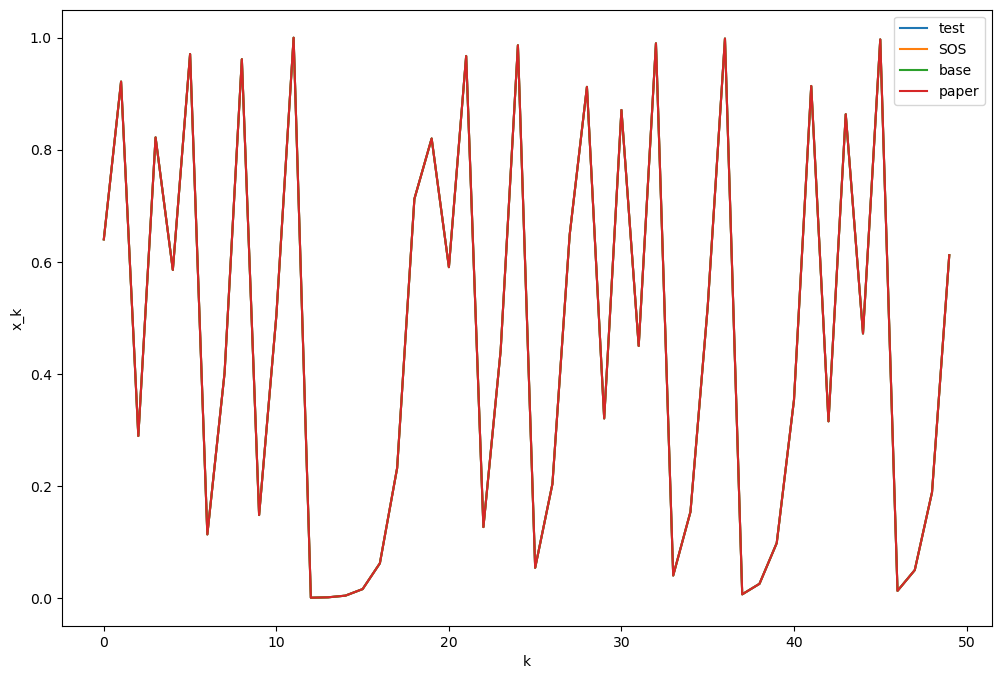

In [439]:
plt.plot(traj_test[1:], label="test")
plt.plot(IPM_res[:-1], label="SOS")
plt.plot(flow_res[:-1], label="base")
plt.plot(paper_res[:-1], label="paper")

plt.legend()
plt.ylabel("x_k")
plt.xlabel("k")

In [447]:
np.linalg.norm(traj_test[1:] - IPM_res[:-1])

4.245927837492902e-07

In [441]:
np.linalg.norm(traj_test[1:] - paper_res[:-1])

1.581997497708402e-07

In [446]:
np.linalg.norm(traj_test[1:] - paper_res[:-1])

3.008220400106258e-07

In [448]:
np.linalg.norm(traj_test[1:] - flow_res[:-1])

1.0568129816912851e-07

In [434]:
np.linalg.norm(traj_test - IPM_res)

3.6331977544177

In [408]:
np.linalg.norm(traj_test - paper_res)

2.385722373354055

In [409]:
np.linalg.norm(traj_test - flow_res)

2.020213986201731